# Data inspection in BigQuery - posts dataset

The data set source is a pubblic collection of 1.7 billion reddit comments and posts loaded on BigQuery in this [link](https://console.cloud.google.com/bigquery?p=fh-bigquery%2F&project=reddit-master&folder&organizationId)

# Posts statistic

Here below the steps followed that guided me to my conclusions of which subreddits I selected through posts_ds.

In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
%env GCLOUD_PROJECT=reddit-master

env: GCLOUD_PROJECT=reddit-master


## Global analysis

Before starting my analysis I what to do some study about the lenght of  `titles` and `self` text considering that:

*   ```selftext``` can contain empty and null data
*   ```selftext``` can be deleted and removed
*   ```title``` with a length too short (not representative for my analysis)

With a small query we can see that this kind of "invalid" data is huge and worth cleaning the data (below a sample in a specific month):

In [0]:
%%bigquery --project reddit-master
SELECT
  COUNT(selftext) AS selftext_not_valid,
  subreddit,
  selftext,
  title
FROM
  `fh-bigquery.reddit_posts.2018_11`
WHERE
  (selftext = '[deleted]' AND length(title) < 20)
  OR (selftext = '[removed]' AND length(title) < 20)
  OR (selftext = '[ Removed by reddit in response to a copyright notice. ]' AND length(title) < 20)
  OR (selftext = 'NaN' AND length(title) < 20)
  OR (selftext = '' AND length(title) < 20)
group by 2, 3, 4

,selftext_not_valid,subreddit,selftext,title
0,1,CassieV,[ Removed by reddit in response to a copyright...,��
1,1,Cricket,[ Removed by reddit in response to a copyright...,JINX CAN BOWL TOO!
2,3,goddesses,[ Removed by reddit in response to a copyright...,Allison Parker
3,1,de,,Hallo! Wie meinen?
4,1,de,,Volvo &gt; Audi
...,...,...,...,...
1439482,2,u_Dunghoanggia,[removed],Bongkhoangrockwool
1439483,1,MrNeal,[removed],Thoughts
1439484,1,u_kiminayuuki,[removed],Fortnite stream
1439485,1,u_JayJoinOurStory,[removed],New to me


From now, the data will be selected and clean with the follow critera:

```
  (selftext != '[deleted]' AND length(title) > 20)
  AND (selftext != '[removed]' AND length(title) > 20)
  AND (selftext != '[ Removed by reddit in response to a copyright notice. ]'     AND length(title) > 20)
  AND (selftext != 'NaN' AND length(title) > 20)
  AND (selftext != '' AND length(title) > 20)
```

In this case, I've decided to keep some "invalid" data in textself where the length of the title is more that 20 char. This because in this table we will consider two text sources and one can cover the information gap of the other.

Let's aplly more filters to my data for best select the information:


*   subreddit
*   author
*   count of title
*   count of selftext
*   average of number of comments per post
*   posts per author
*   score
*   year
*   month

Some important point:

*   ```num_comments```is an important information, the average can give an idea of the post most commented (and indirectually most popular)
*   ```posts_per_authors``` is an information that gives the number of post published per author

This last calculated field is the one I decided to use for filter the query ( ```posts_per_authors``` < 10) because gives us popularity information (number of unique authors that wirte a post) along with number of posts __excluding exorbitant numbers of posts done in both__.



For example, `AskReddit` or `politics` are subreddit really famouse and the number of comments per authors are a realistic number. 

In [0]:
%%bigquery --project reddit-master
WITH
  q1 AS(
  SELECT
    subreddit,
    author,
    title,
    selftext,
    num_comments,
    score,
    created_utc
  FROM
    `fh-bigquery.reddit_posts.2018*`),
  q2 AS (
  SELECT
    DISTINCT(subreddit) uniq_subreddit,
    COUNT(DISTINCT(author)) AS num_uniq_authors,
    COUNT(title) AS number_titles,
    ROUND(AVG(num_comments),2) AS avg_comments_in_post,
    ROUND((COUNT(title) / COUNT(DISTINCT(author))),2) AS posts_per_author,
    EXTRACT(YEAR
    FROM
      TIMESTAMP_SECONDS(created_utc)) year,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    q1
  GROUP BY
    1,
    6,
    7
  ORDER BY
    number_titles DESC)
SELECT
  uniq_subreddit,
  num_uniq_authors,
  number_titles,
  avg_comments_in_post,
  posts_per_author,
  year,
  month
FROM
  q2
WHERE
  uniq_subreddit in ('AskReddit', 'politics')
ORDER BY
  number_titles DESC

,uniq_subreddit,num_uniq_authors,number_titles,avg_comments_in_post,posts_per_author,year,month
0,AskReddit,101172,303782,18.82,3.00,2018,12
1,AskReddit,90567,273330,19.42,3.02,2018,11
2,AskReddit,91971,268330,20.68,2.92,2018,10
3,AskReddit,82818,249696,21.45,3.01,2018,7
4,AskReddit,85349,248169,22.20,2.91,2018,8
5,AskReddit,81699,243767,21.49,2.98,2018,5
6,AskReddit,83782,241637,20.41,2.88,2018,1
7,AskReddit,77874,240232,20.79,3.08,2018,4
8,AskReddit,83667,239690,20.75,2.86,2018,3
9,AskReddit,81748,235608,21.13,2.88,2018,9


We can not say the same about `kfq` in mach 2019

In [0]:
%%bigquery --project reddit-master
WITH
  q1 AS(
  SELECT
    subreddit,
    author,
    title,
    selftext,
    num_comments,
    score,
    created_utc
  FROM
    `fh-bigquery.reddit_posts.2019*`),
  q2 AS (
  SELECT
    DISTINCT(subreddit) uniq_subreddit,
    COUNT(DISTINCT(author)) AS num_uniq_authors,
    COUNT(title) AS number_titles,
    ROUND(AVG(num_comments),2) AS avg_comments_in_post,
    ROUND((COUNT(title) / COUNT(DISTINCT(author))),2) AS posts_per_author,
    EXTRACT(YEAR
    FROM
      TIMESTAMP_SECONDS(created_utc)) year,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    q1
  GROUP BY
    1,
    6,
    7
  ORDER BY
    number_titles DESC)
SELECT
  uniq_subreddit,
  num_uniq_authors,
  number_titles,
  avg_comments_in_post,
  posts_per_author,
  year,
  month
FROM
  q2
WHERE
  uniq_subreddit in ('kfq')
  AND month = 3
ORDER BY
  number_titles DESC

,uniq_subreddit,num_uniq_authors,number_titles,avg_comments_in_post,posts_per_author,year,month
0,kfq,6,94664,21.06,15777.33,2019,3


Finally, as post table has times less dimention compared with the comments table, I've decided to reduce the limits of the length in `title` and `selftext` respectively in mayor than 10 and 15, to best represent the data necessary for my model and, in posts per comments, upper than 10 considering it as a inicator of popularity.

In [0]:
%%bigquery --project reddit-master
WITH
  q1 AS(
  SELECT
    subreddit,
    author,
    title,
    selftext,
    num_comments,
    score,
    created_utc
  FROM
    `fh-bigquery.reddit_posts.2018_*`
  WHERE
    LENGTH(title) > 10
    AND LENGTH(selftext) > 15
      AND (selftext != '[deleted]' AND length(title) > 15)
      AND (selftext != '[removed]' AND length(title) > 15)
      AND (selftext != '[ Removed by reddit in response to a copyright notice. ]' AND length(title) > 15)
      AND (selftext != 'NaN' AND length(title) > 15)
      AND (selftext != '' AND length(title) > 15)),
  q2 AS (
  SELECT
    DISTINCT(subreddit) uniq_subreddit,
    COUNT(DISTINCT(author)) AS num_uniq_authors,
    COUNT(title) AS number_titles, --selftext is not consider because give me the same result as title
    ROUND(AVG(num_comments),2) AS avg_comments_in_post,
    ROUND((COUNT(title) / COUNT(DISTINCT(author))),2) AS posts_per_author,
    ROUND(AVG(score), 2) AS avg_score,
    EXTRACT(YEAR
    FROM
      TIMESTAMP_SECONDS(created_utc)) year,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    q1
  GROUP BY
    1,
    7,
    8
  ORDER BY
    number_titles DESC)
SELECT
  uniq_subreddit,
  num_uniq_authors,
  number_titles,
  avg_comments_in_post,
  posts_per_author,
  avg_score,
  year,
  month
FROM
  q2
WHERE
  posts_per_author < 10
  AND avg_comments_in_post > 30
ORDER BY
  number_titles DESC


,uniq_subreddit,num_uniq_authors,number_titles,avg_comments_in_post,posts_per_author,avg_score,year,month
0,CryptoCurrency,7502,11263,39.21,1.50,49.56,2018,1
1,leagueoflegends,8039,10962,30.59,1.36,99.31,2018,1
2,DestinyTheGame,6163,10738,31.52,1.74,94.69,2018,5
3,leagueoflegends,7681,10480,35.87,1.36,106.80,2018,3
4,leagueoflegends,7117,10113,31.98,1.42,89.77,2018,6
...,...,...,...,...,...,...,...,...
12437,HailCorporateDrama,1,1,59.00,1.00,24.00,2018,7
12438,furry_irl,1,1,49.00,1.00,727.00,2018,10
12439,TreesHouseOfGWA,1,1,37.00,1.00,37.00,2018,10
12440,Integral,1,1,32.00,1.00,7.00,2018,1


Let's see with Data Studio the visualization of our data.

As for comments ds, also in posts can be usefull analyze `number_comments` and `num_uniq_authors` separately

In [0]:
from google.colab import files
uploaded = files.upload()

Saving posts_numbComments_unicAuthors.png to posts_numbComments_unicAuthors.png


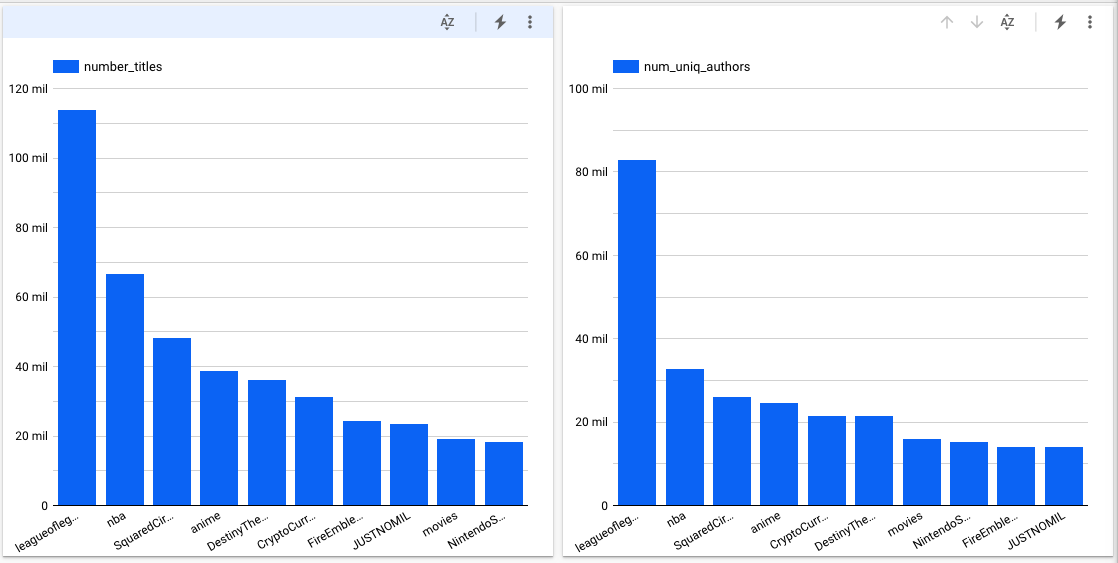

In [0]:
from IPython.display import Image
Image('posts_numbComments_unicAuthors.png', width = 1000)

There is a correlation between number of post published and number of unique authors.

## Top subreddits per year - posts table

The final solution for my analysis is to extract:

*   the top n subreddits with more posts published on it
*   the top n subreddit with more unique authors that writes on them


Finally, with this data, I'll study each subreddit selecting:

*   those with a costant popularity during the years 
*   those that cover a wider category threshold

For the last point I'll use the follow public classification on GitHub: [subreddit-Directory-Skeleton](https://github.com/MetASnoo/Subreddit-Directory-Skeleton/blob/master/subreddits.txt)

### Top posts in all years

The query will run all `reddit_posts` talble from 2005 to 2019. 

Here below again a summary of the fileters applied, tried several time in order to find the best solution for my model.

*   cleaned data from empty or deleted data
*   title con has a length of 10 character because I want to exclude short texts
*   selftext has a lenght of 15, a bit longer than title, because we suppose this is a common standard and I also exclude the too shorts texts
*   posts_per_author
*   avg_comments_in_post


With this query, I'll create a table with all posts per subreddit, year and month:

```sql
WITH
  q1 AS(
  SELECT
    subreddit,
    author,
    title,
    selftext,
    num_comments,
    score,
    created_utc
  FROM
    `fh-bigquery.reddit_posts.20*`
  WHERE
    LENGTH(title) > 10
    AND LENGTH(selftext) > 15
      AND (selftext != '[deleted]' AND length(title) > 15)
      AND (selftext != '[removed]' AND length(title) > 15)
      AND (selftext != '[ Removed by reddit in response to a copyright notice. ]' AND length(title) > 15)
      AND (selftext != 'NaN' AND length(title) > 15)
      AND (selftext != '' AND length(title) > 15)),
  q2 AS (
  SELECT
    DISTINCT(subreddit) uniq_subreddit,
    COUNT(DISTINCT(author)) AS num_uniq_authors,
    COUNT(title) AS number_titles, --selftext is not consider because give me the same result as title
    ROUND(AVG(num_comments),2) AS avg_comments_in_post,
    ROUND((COUNT(title) / COUNT(DISTINCT(author))),2) AS posts_per_author,
    ROUND(AVG(score), 2) AS avg_score,
    EXTRACT(YEAR
    FROM
      TIMESTAMP_SECONDS(created_utc)) year,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    q1
  GROUP BY
    1,
    7,
    8
  ORDER BY
    number_titles DESC)
SELECT
  uniq_subreddit,
  num_uniq_authors,
  number_titles,
  avg_comments_in_post,
  posts_per_author,
  avg_score,
  year,
  month
FROM
  q2
WHERE
  posts_per_author < 10
  AND avg_comments_in_post > 30
ORDER BY
  number_titles DESC

````



The filters of length in title and selftest done in the previous query give us data with not much histoy in title:

In [0]:
%%bigquery --project reddit-master
SELECT
  MAx(number_of_months) as max_month
FROM (
  SELECT
    uniq_subreddit,
    SUM(number_titles) AS total_titles,
    max(year) as last_year_commented,
    COUNT(month) AS number_of_months
  FROM
    `reddit-master.reddit_posts_data.count_title_allYears_V4`
  GROUP BY
    uniq_subreddit
  ORDER BY
    total_titles DESC)

,max_month
0,45


Based in the result of the previous query, I've created a table where I decided to extract:

- __subreddit__
- __sum of titles__ : that gives me the subreddits with most titles throughout the life of Reddit:
- __count of months__ :in order to identify the subreddits that has been commented during several months and years 
- __last year commented__: the las year where a comment has been done

limited in 100 results.

This gives me an idea of which subreddits deserve to be analyzed for my purpose.

__As 2019 is the last year commented it gives me the security that the subreddits I select are the ones with more comments in several months and are still commented in 2019__

File name: __titles_top100.csv__

In [0]:
%%bigquery --project reddit-master
SELECT
  *
FROM (
  SELECT
    uniq_subreddit,
    SUM(number_titles) AS total_titles,
    max(year) as last_year_commented,
    COUNT(month) AS number_of_months
  FROM
    `reddit-master.reddit_posts_data.count_title_allYears_V4`
  GROUP BY
    uniq_subreddit
  ORDER BY
    total_titles DESC)
LIMIT 100

,uniq_subreddit,total_titles,last_year_commented,number_of_months
0,leagueoflegends,277930,2019,29
1,SquaredCircle,209900,2019,45
2,nba,203999,2019,45
3,DestinyTheGame,172268,2018,25
4,anime,154751,2019,45
...,...,...,...,...
95,canada,17444,2019,41
96,reddevils,17040,2019,45
97,running,17019,2019,32
98,sportsbook,16966,2019,43


### Top unique authors in all years


Unique authors (the number of authors that wrote a comment) will follow the same tratment of posts. The query will be the same as the previous but this time, order by the number of unique authors:

```sql
WITH
  q1 AS(
  SELECT
    subreddit,
    author,
    title,
    selftext,
    num_comments,
    score,
    created_utc
  FROM
    `fh-bigquery.reddit_posts.20*`
  WHERE
    LENGTH(title) > 10
    AND LENGTH(selftext) > 15
      AND (selftext != '[deleted]' AND length(title) > 15)
      AND (selftext != '[removed]' AND length(title) > 15)
      AND (selftext != '[ Removed by reddit in response to a copyright notice. ]' AND length(title) > 15)
      AND (selftext != 'NaN' AND length(title) > 15)
      AND (selftext != '' AND length(title) > 15)),
  q2 AS (
  SELECT
    DISTINCT(subreddit) uniq_subreddit,
    COUNT(DISTINCT(author)) AS num_uniq_authors,
    COUNT(title) AS number_titles, --selftext is not consider because give me the same result as title
    ROUND(AVG(num_comments),2) AS avg_comments_in_post,
    ROUND((COUNT(title) / COUNT(DISTINCT(author))),2) AS posts_per_author,
    ROUND(AVG(score), 2) AS avg_score,
    EXTRACT(YEAR
    FROM
      TIMESTAMP_SECONDS(created_utc)) year,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    q1
  GROUP BY
    1,
    7,
    8
  ORDER BY
    number_titles DESC)
SELECT
  uniq_subreddit,
  num_uniq_authors,
  number_titles,
  avg_comments_in_post,
  posts_per_author,
  avg_score,
  year,
  month
FROM
  q2
WHERE
  posts_per_author < 10
  AND avg_comments_in_post > 30
ORDER BY
  num_uniq_authors DESC

```

Based in the result of the previous query, I've created a table where I decided to extract to inspect:

- __subreddit__
- __sum of unique authors__ (that gives me the most "famous" subreddits throughout the life of Reddit)
- __count of months__ in order to identify the subreddits that has been commented during several months and yeras
- __last year commented__: the las year where a comment has been done

limited in 100 results.

Once again, this gives me an idea of which subreddits deserve to be analyzed for my purpose.

__As 2019 is the last year commented it gives me the security that the subreddits I select are the ones with more comments from unique authors in several months and are still commented in 2019__

File name: __authors_in_posts_top100.csv__


In [0]:
%%bigquery --project reddit-master
SELECT
  *
FROM (
  SELECT
    uniq_subreddit,
    SUM(num_uniq_authors) AS total_authors_in_posts,
    max(year) as last_year_commented,
    COUNT(month) AS number_of_months
  FROM
    `reddit-master.reddit_posts_data.count_uniq_authors_posts_allYears_V4`
  GROUP BY
    uniq_subreddit
  ORDER BY
    total_authors_in_posts DESC)
LIMIT 100

,uniq_subreddit,total_authors_in_posts,last_year_commented,number_of_months
0,leagueoflegends,201692,2019,29
1,SquaredCircle,111661,2019,45
2,DestinyTheGame,105841,2018,25
3,nba,104106,2019,45
4,anime,95410,2019,45
...,...,...,...,...
95,CasualUK,12593,2019,31
96,AskAnAmerican,12549,2019,45
97,grandorder,12526,2019,35
98,ukpolitics,12506,2019,44
